In [3]:
!pip install pyarrow
!pip install -e orpheus_tts_pypi
!pip install python-dotenv

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
ERROR: orpheus_tts_pypi is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).
Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from ask_lisa import ask_lisa
from dotenv import load_dotenv

In [3]:
base_dir = "asr_bundestag_clean"
train = base_dir + "/train_nodev"
validate = base_dir + "/train_dev"
test = base_dir + "/test"

load_dotenv()

True

In [4]:
mapping = {}

with open(train + "/wav.scp", "r", encoding="utf-8") as f:
    for line in f:
        words = line.strip().split()
        mapping.update({words[0]: [words[1]]})

for i, (key, value) in enumerate(mapping.items()):
    if i >= 5:
        break
    print(key, ": ", value)

7535988_0_172_12 :  ['wavs/7535988_0_172_12.wav']
7536262_0_15_7 :  ['wavs/7536262_0_15_7.wav']
7546736_0_163_2 :  ['wavs/7546736_0_163_2.wav']
7511688_0_142_16 :  ['wavs/7511688_0_142_16.wav']
7535129_3_253 :  ['wavs/7535129_3_253.wav']


In [5]:
with open(train + "/text", "r", encoding="utf-8") as f:
    for line in f:
        words = line.strip().split(maxsplit=1)
        mapping[words[0]].append(words[1])

for i, (key, value) in enumerate(mapping.items()):
    if i >= 2:
        break
    print(key, ": ", value)

7535988_0_172_12 :  ['wavs/7535988_0_172_12.wav', 'das bedeutet jetzt dass die länder auf jeden fall daten erheben müssen']
7536262_0_15_7 :  ['wavs/7536262_0_15_7.wav', 'kein geschenk das ist verdient meine damen und herren']


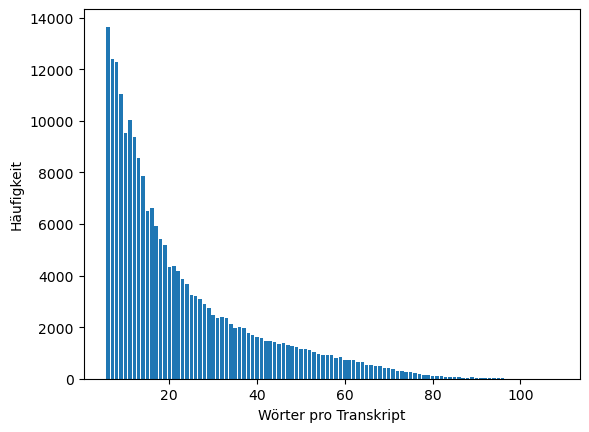

In [6]:
word_count = {}
with open(train + "/text", "r", encoding="utf-8") as f:
    for line in f:
        count = len(line.strip().split()) - 1
        if count in word_count:
            word_count[count] = word_count[count] + 1
        else:
            word_count[count] = 1

counts = sorted(word_count.keys())
frequencies = [word_count[c] for c in counts]

plt.bar(counts, frequencies)
plt.xlabel("Wörter pro Transkript")
plt.ylabel("Häufigkeit")
plt.show()

In [7]:
filtered_mapping = {}
for key, value in mapping.items():
    count = len(value[1].split())
    if 70 < count < 1000:
        filtered_mapping.update({key: value})

mapping = filtered_mapping

for i, (key, value) in enumerate(mapping.items()):
    if i >= 5:
        break
    print(key, ": ", value)

print(len(mapping.items()))

7506424_2_69 :  ['wavs/7506424_2_69.wav', 'cdu csu fraktion frau präsidentin meine sehr geehrten damen und herren liebe kolleginnen und kollegen wo man am meisten drauf erpicht grad das bekommt man meistens nicht liebe kolleginnen und kollegen von den linken und den grünen dieses zitat von wilhelm busch passt perfekt zu ihren anträgen gern erläutere ich warum das so ist sie fordern dass die co kosten allein den vermieterinnen und vermietern aufgebürdet werden sollen und erhoffen sich hierdurch dass die energetische sanierung der gebäude angereizt wird']
7520734_0_99_1 :  ['wavs/7520734_0_99_1.wav', 'hat kann man davon ausgehen dass die regulierung der europäischen union egal ob das jetzt eine verordnung oder eine direktive wird dieselbe richtung gehen wird sie wird detaillierter sein sie wird bestimmte dinge nochmal ausführlicher auch sicher ausbuchstabieren ich halte das deutsche gesetz für eine gute vorbereitung und letzten endes gibt es den deutschen unternehmen da auch ein stück we

In [8]:
import json
from ask_lisa import ask_lisa

def generate_qa(context, difficulty):
    system_prompt = f"""
    Erstelle aus dem folgenden Kontext Frage-Antwort-Paare für drei Komplexitätsstufen.

    - Jede Antwort soll präzise und kurz sein.
    - Stelle die Fragen so, als 
    - Gib das Ergebnis ausschließlich als JSON-Objekt mit den Keys "level_1", "level_2" und "level_3" aus.
    - Unter jedem Key steht wiederum ein JSON-Objekt mit "question" und "answer".
    - Keine anderen Texte oder Erklärungen ausgeben.
    - nutze keine Füll- oder Bindewörter sondern formuliere die Antworten stichpunktartig

    Definition der Komplexitätsgrade:
    1 = sehr einfache, faktische Frage - max. 2 Worte
    2 = inhaltlich tiefergehende, aber kurze Frage - keine Wort-Limits
    3 = analytische oder interpretierende Frage (z. B. Ursache, Wirkung, Ziel) - keine Wort-Limits

    Beispiele:
    Beispielkontext: cdu csu fraktion frau präsidentin meine sehr geehrten damen und herren liebe kolleginnen und kollegen wo man am meisten drauf erpicht grad das bekommt man meistens nicht liebe kolleginnen und kollegen von den linken und den grünen dieses zitat von wilhelm busch passt perfekt zu ihren anträgen gern erläutere ich warum das so ist sie fordern dass die co kosten allein den vermieterinnen und vermietern aufgebürdet werden sollen und erhoffen sich hierdurch dass die energetische sanierung der gebäude angereizt wird
    Beispiel Fragen/Antworten:
    {{
      "level_1": {{ "question": "Wer wird angesprochen?", "answer": "Linke, Grüne" }},
      "level_2": {{ "question": "Was wird gefordert?", "answer": "CO-Kosten übernehmen" }},
      "level_3": {{ "question": "Warum sollen Vermieter zahlen?", "answer": "Sanierungsanreiz" }}
    }}

    Beispielkontext: hat kann man davon ausgehen dass die regulierung der europäischen union egal ob das jetzt eine verordnung oder eine direktive wird dieselbe richtung gehen wird sie wird detaillierter sein sie wird bestimmte dinge nochmal ausführlicher auch sicher ausbuchstabieren ich halte das deutsche gesetz für eine gute vorbereitung und letzten endes gibt es den deutschen unternehmen da auch ein stück wettbewerbsvorsprung ich weiß es wird jetzt hier sehr konservativ diskutiert nach dem motto na ja
    eispiel Fragen/Antworten:
    {{
      "level_1": {{ "question": "Was wird detaillierter sein?", "answer": "Verordnung" }},
      "level_2": {{ "question": "Welchen Vorteil hat das deutsche Gesetz?", "answer": "Es ermöglicht deutschen Unternehmen einen Wettbewerbsvorsprung" }},
      "level_3": {{ "question": "Wie unterscheidet sich die Verordnung der europäischen Union vom deutschen Gesetz?", "answer": "Die Verordnung der europäischen Union wird detaillierter sein als das deutsche Gesetz?" }}
      }}
    """

    qa_res = ask_lisa(system_prompt, context)

    try:
        qa_all = json.loads(qa_res)
    except json.JSONDecodeError:
        print("Antwort war kein gültiges JSON:", qa_res)
        return None, None, difficulty

    key_map = {1: "level_1", 2: "level_2", 3: "level_3"}
    key = key_map.get(difficulty)

    qa = qa_all.get(key, {})
    question = qa.get("question", "")
    answer = qa.get("answer", "")

    return question, answer, difficulty


In [ ]:
generate_qa("es gibt zahlreiche nicht abklingende proteste es gibt initiativen es gibt self made projekte petitionen umfragen zeigen dass große teile der gesellschaft bereit sind jetzt wo wir hier reden haben wir vor dem bundestag eine begleitende kundgebung mit über zehn bewegungen und es gibt jetzt gerade redebeiträge und die zeigen ihnen auch wieder dass es nicht nur diese petition ist sondern dass es hunderttausende wenn nicht sogar millionen von menschen sind die tagtäglich immer wieder dafür kämpfen dass hier endlich was passiert im bereich der mobilitäts und verkehrswende zum schluss", 1)

In [ ]:
generate_qa("es gibt zahlreiche nicht abklingende proteste es gibt initiativen es gibt self made projekte petitionen umfragen zeigen dass große teile der gesellschaft bereit sind jetzt wo wir hier reden haben wir vor dem bundestag eine begleitende kundgebung mit über zehn bewegungen und es gibt jetzt gerade redebeiträge und die zeigen ihnen auch wieder dass es nicht nur diese petition ist sondern dass es hunderttausende wenn nicht sogar millionen von menschen sind die tagtäglich immer wieder dafür kämpfen dass hier endlich was passiert im bereich der mobilitäts und verkehrswende zum schluss", 2)

In [ ]:
generate_qa("es gibt zahlreiche nicht abklingende proteste es gibt initiativen es gibt self made projekte petitionen umfragen zeigen dass große teile der gesellschaft bereit sind jetzt wo wir hier reden haben wir vor dem bundestag eine begleitende kundgebung mit über zehn bewegungen und es gibt jetzt gerade redebeiträge und die zeigen ihnen auch wieder dass es nicht nur diese petition ist sondern dass es hunderttausende wenn nicht sogar millionen von menschen sind die tagtäglich immer wieder dafür kämpfen dass hier endlich was passiert im bereich der mobilitäts und verkehrswende zum schluss", 3)

In [10]:
from orpheus_tts import OrpheusModel
import wave
import os

from huggingface_hub import login
login(token=os.getenv("HUGGINGFACE_TOKEN"))

# Modell initialisieren
model = OrpheusModel(model_name ="canopylabs/3b-de-ft-research_release", max_model_len=2048)

def to_speech(text, key):
    # Audio generieren (streaming)
    syn_tokens = model.generate_speech(
        prompt=text,
        voice="default"  # Für deutsche Modelle, prüfe verfügbare Voices
    )
    
    # Als WAV speichern
    with wave.open("output.wav", "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(24000)
        
        for audio_chunk in syn_tokens:
            wf.writeframes(audio_chunk)


TypeError: OrpheusModel.__init__() got an unexpected keyword argument 'max_model_len'

In [ ]:
keys = list(mapping.keys())
     
for i in range(1):
    key = random.choice(keys)
    print(mapping[key][1])
    question, answer, diff = generate_qa(mapping[key][1], 1)
    to_speech(question)
    